In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


35947 points


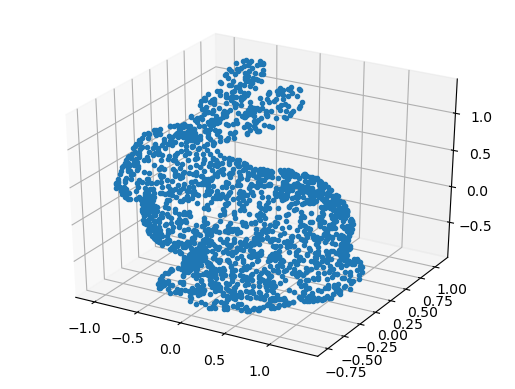

In [2]:
from plyfile import PlyData
plydata = PlyData.read('bun_zipper.ply')
# plydata = PlyData.read('dragon_vrip.ply')

data = plydata.elements[0].data

p = np.array([data['x'], -data['z'], data['y']]).T
p -= np.mean(p, axis=0)
p /= np.mean(np.sum(p*p, axis=1)) ** 0.5
N = p.shape[0]
print(N, 'points')

plt.figure()
ax = plt.axes(projection='3d')
i = np.arange(N)
np.random.shuffle(i)
i = i[:2000]
ax.plot(p[i,0], p[i,1], p[i,2], '.')
plt.show()

In [4]:
class Model(nn.Module):
    def __init__(self, ni, nh, no):
        super(Model, self).__init__()

        self.is_same = (ni == nh)
        self.activation = torch.sin
        self.layer1 = nn.Linear(ni, nh)
        self.layer2 = nn.Linear(nh, nh)
        self.layer3 = nn.Linear(nh, nh)
        self.layer4 = nn.Linear(nh, nh)
        self.layer5 = nn.Linear(nh, nh)
        self.layer6 = nn.Linear(nh, no)

    def forward(self, x):
        xm = self.activation(self.layer1(x))
        if self.is_same:
            xm += x
        xm = self.activation(self.layer2(xm))+xm
        xm = self.activation(self.layer3(xm))+xm
        xm = self.activation(self.layer4(xm))+xm
        xm = self.activation(self.layer5(xm))+xm
        return self.layer6(xm)

NZ = 8
NH = 8
ND = 3

encoder = Model(ND, NH, NZ).to(device)
decoder = Model(NZ, NH, ND).to(device)

print(encoder)
print(decoder)

Model(
  (layer1): Linear(in_features=3, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=8, bias=True)
  (layer4): Linear(in_features=8, out_features=8, bias=True)
  (layer5): Linear(in_features=8, out_features=8, bias=True)
  (layer6): Linear(in_features=8, out_features=8, bias=True)
)
Model(
  (layer1): Linear(in_features=8, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=8, bias=True)
  (layer4): Linear(in_features=8, out_features=8, bias=True)
  (layer5): Linear(in_features=8, out_features=8, bias=True)
  (layer6): Linear(in_features=8, out_features=3, bias=True)
)


In [17]:
def chamfer_distance(pc1, pc2):
    # Calculate pairwise distances
    pairwise_distances_pc1_pc2 = torch.cdist(pc1, pc2, p=2)
    pairwise_distances_pc2_pc1 = torch.cdist(pc2, pc1, p=2)

    # Find the nearest neighbors for each point
    nearest_neighbors_pc1 = torch.min(pairwise_distances_pc1_pc2, dim=1).values
    nearest_neighbors_pc2 = torch.min(pairwise_distances_pc2_pc1, dim=1).values

    # Calculate the Chamfer distance
    chamfer_loss = torch.mean(nearest_neighbors_pc1) + torch.mean(nearest_neighbors_pc2)

    return chamfer_loss


data = torch.tensor(p, dtype=torch.float32, device=device)

optimizer_e = torch.optim.Adam(
    encoder.parameters(),
    lr=0.001
)
optimizer_d = torch.optim.Adam(
    decoder.parameters(),
    lr=0.001
)

soboleng = torch.quasirandom.SobolEngine(dimension=NZ)

def rand_lds(n):
    u = soboleng.draw(n).to(device)
    return torch.erfinv(1.9999*(u-0.5))


batch_size = 2048

for batch_i in range(20000):
    i = torch.arange(0, batch_size, dtype=torch.int64, device=device)
    i = ((i + batch_i*batch_size) * 131407079) % len(data)

    x = data[i]
    z = encoder(x)
    y = decoder(z)
    # loss_diff = 0.5 * torch.mean(torch.abs(y-x))
    loss_diff = 0.5 * torch.mean((y-x)**2)
    # loss_diff = 0.5 * loss_diff + 0.2 * loss_diff ** 0.5
    # loss_diff = 0.5 * torch.mean((y-x)**2) ** 0.5

    z = rand_lds(batch_size)
    y = decoder(z)
    loss_vae = 1.0 * chamfer_distance(y, x)

    loss = loss_diff + loss_vae

    encoder.zero_grad()
    decoder.zero_grad()
    loss.backward()
    optimizer_e.step()
    optimizer_d.step()

    if (batch_i+1) % 1000 == 0:
        print('%d diff %.4f, vae %.4f, total %.4f' % (
            batch_i+1, loss_diff.item(), loss_vae.item(), loss.item()))


1000 diff 0.0003, vae 0.0961, total 0.0963
2000 diff 0.0003, vae 0.0974, total 0.0977
3000 diff 0.0003, vae 0.0969, total 0.0972
4000 diff 0.0003, vae 0.0963, total 0.0965
5000 diff 0.0003, vae 0.0971, total 0.0973
6000 diff 0.0003, vae 0.0966, total 0.0969
7000 diff 0.0002, vae 0.0961, total 0.0963
8000 diff 0.0002, vae 0.0961, total 0.0964
9000 diff 0.0002, vae 0.0942, total 0.0944
10000 diff 0.0002, vae 0.0968, total 0.0970
11000 diff 0.0002, vae 0.0950, total 0.0953
12000 diff 0.0002, vae 0.0953, total 0.0955
13000 diff 0.0002, vae 0.0967, total 0.0969
14000 diff 0.0002, vae 0.0966, total 0.0968
15000 diff 0.0003, vae 0.0973, total 0.0975
16000 diff 0.0002, vae 0.0957, total 0.0959
17000 diff 0.0002, vae 0.0966, total 0.0968
18000 diff 0.0002, vae 0.0948, total 0.0950
19000 diff 0.0002, vae 0.0965, total 0.0967
20000 diff 0.0002, vae 0.0964, total 0.0966


(4096, 3)


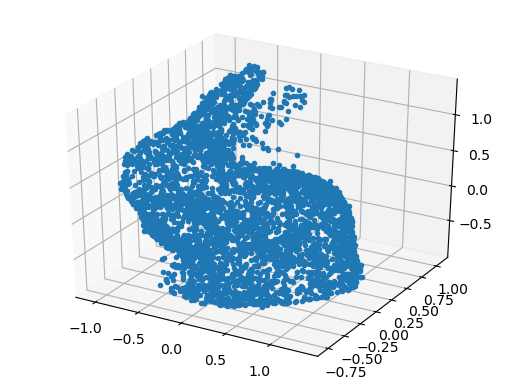

In [18]:
z = rand_lds(2*batch_size)

with torch.no_grad():
    y = decoder(z)

y = y.detach().cpu().numpy()
print(y.shape)

plt.figure()
ax = plt.axes(projection='3d')
ax.plot(y[:,0], y[:,1], y[:,2], '.')
plt.show()
plt.show()

In [19]:
varname = "abcdefghijklmnopqrstuvwxyz"

print("N=2500")
print("I=\\left[0...N-1\\right]+0.5")

print("R\\left(u\\right)=\\sqrt{-2\\ln\\left(1-0.8u\\right)}")

varnames = [f"a_{{{i}}}" for i in range(NZ)]

assert NZ % 2 == 0

us = []
for i in range(NZ):
    primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
    u = "\\frac{I}{N}" if i==0 else "\\operatorname{mod}\\left(\\sqrt{"+str(primes[i-1])+"}I,1\\right)"
    us.append(u)

for i in range(NZ):
    # s = varnames[i] + "=R\\left(\\operatorname{random}\\left(N\\right),\\operatorname{random}\\left(N\\right)\\right)"
    u = us[2*(i//2)]
    v = us[2*(i//2)+1]
    s = varnames[i] + "=R\\left("+u+"\\right)\\"+['cos','sin'][i%2]+"\\left(2\\pi"+v+"\\right)"
    print(s)

layer = 0
params = list(decoder.parameters())
for layer in range(0, len(params)//2):
    w = params[2*layer]
    b = params[2*layer+1]
    # print(w.shape, b.shape)
    varnames1 = [f"{varname[layer+1]}_{{{i}}}" for i in range(len(b))]
    for i in range(len(b)):
        s = varnames1[i] + '='
        if 2*layer+2 < len(params):
            s += "\\sin\\left("
        for j in range(w.shape[1]):
            t = ("{:"+'+'*int(j>0)+".3g}").format(w[i][j])
            if 'e' not in t:
                s += t + varnames[j]
        t = ("{:"+'+'*int(j>0)+".3g}").format(b[i])
        if 'e' not in t:
            s += ("{:"+'+'*int(j>0)+".3g}").format(b[i])
        if 2*layer+2 < len(params):
            s += "\\right)"
        if (layer > 0 or len(varnames) == len(varnames1)) and 2*layer+2 < len(params):
            s += '+'+varnames[i]
        print(s)
    varnames = varnames1

print('\\left('+','.join(varnames)+'\\right)')
print(f"c=\\operatorname{{rgb}}\\left(128+128{varnames[0]},128+128{varnames[1]},128+128{varnames[2]}\\right)")

N=2500
I=\left[0...N-1\right]+0.5
R\left(u\right)=\sqrt{-2\ln\left(1-0.8u\right)}
a_{0}=R\left(\frac{I}{N}\right)\cos\left(2\pi\operatorname{mod}\left(\sqrt{2}I,1\right)\right)
a_{1}=R\left(\frac{I}{N}\right)\sin\left(2\pi\operatorname{mod}\left(\sqrt{2}I,1\right)\right)
a_{2}=R\left(\operatorname{mod}\left(\sqrt{3}I,1\right)\right)\cos\left(2\pi\operatorname{mod}\left(\sqrt{5}I,1\right)\right)
a_{3}=R\left(\operatorname{mod}\left(\sqrt{3}I,1\right)\right)\sin\left(2\pi\operatorname{mod}\left(\sqrt{5}I,1\right)\right)
a_{4}=R\left(\operatorname{mod}\left(\sqrt{7}I,1\right)\right)\cos\left(2\pi\operatorname{mod}\left(\sqrt{11}I,1\right)\right)
a_{5}=R\left(\operatorname{mod}\left(\sqrt{7}I,1\right)\right)\sin\left(2\pi\operatorname{mod}\left(\sqrt{11}I,1\right)\right)
a_{6}=R\left(\operatorname{mod}\left(\sqrt{13}I,1\right)\right)\cos\left(2\pi\operatorname{mod}\left(\sqrt{17}I,1\right)\right)
a_{7}=R\left(\operatorname{mod}\left(\sqrt{13}I,1\right)\right)\sin\left(2\pi\operatorname{mod